# Experiments

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# company = "reit"
# company = "yellow_pages"
company = "calyxt"

test_pdf_path = f"../data/eval/{company}.pdf"

## Docling - strong!

In [3]:
# Potential for parallelization for files?
from docling.document_converter import DocumentConverter

# source = "https://arxiv.org/pdf/2408.09869"  # document per local path or URL
converter = DocumentConverter()
result = converter.convert(test_pdf_path)
print(result.document.export_to_markdown())

# REIT: execution for 7.4MB with 97 pages -> 5 min
# Yellow Pages: execution for 1.4MB with 77 pages -> 4 min
# Calyxt: execution for 0.7MB with 88 pages -> 3min

KeyboardInterrupt: 

In [ ]:
# domain knwoledge
# brackets in tables indicate negative values
# parsing issues (see current system prompt)

In [22]:
# STORE as md with correct utf-8 encoding
with open(f"../dev/docling_{company}.md", "w", encoding="utf-8") as file:
    file.write(result.document.export_to_markdown())

## Custom Advanced Chunking

In [3]:
# Load markdown
with open(f"../dev/docling_{company}.md", "r", encoding="utf-8") as file:
    text = file.read()

In [4]:
# Analysis of chunk lengths if splitting by chapters
import re
import pandas as pd

chunks = re.split(r'(?m)(?=^#+\s)', text)
chunks_cleaned = [chunk for chunk in chunks if chunk.strip()]
char_counts = [len(chunk) for chunk in chunks_cleaned]

pd.Series(char_counts).describe()

count      271.000000
mean      1579.236162
std       2013.277228
min         11.000000
25%        284.000000
50%        980.000000
75%       2012.500000
max      17569.000000
dtype: float64

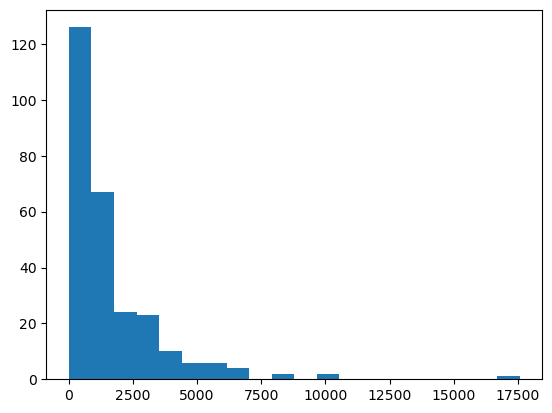

In [5]:
import matplotlib.pyplot as plt

plt.hist(char_counts, bins=20)
plt.show()

In [6]:
# Idea: Try to retrieve Table of Contents from PDF and attach to context first
# Then, chunk the document, attach as metadata the previous X section titles (retrieve via markdown) + page number?
# Split by chapters? If section too large, split into subsections with table correction?

In [7]:
import re

def is_table_paragraph(paragraph):
    """
    Returns True if the paragraph looks like a markdown table block.
    We assume that a table block consists of lines that begin with '|'
    and that at least one line is a separator (i.e. contains a series of dashes).
    """
    lines = paragraph.strip().splitlines()
    if not lines:
        return False
    if not all(line.lstrip().startswith('|') for line in lines):
        return False
    for line in lines:
        if re.search(r'\|\s*-{2,}', line):
            return True
    return False

def get_overlap_text(text, desired_overlap, max_overlap=None):
    """
    Extracts an overlap string from the end of `text` made up of whole words.

    Args:
        text (str): The text from which to extract the overlap.
        desired_overlap (int): Desired minimum number of characters to include in the overlap.
        max_overlap (int or None): Maximum allowed overlap (in characters). If None, no hard cap is applied.

    Returns:
        str: A string composed of whole words from the end of `text` whose total length
             is at least `desired_overlap` (if possible) but not exceeding `max_overlap` (if provided).
    """
    if max_overlap is None:
        max_overlap = desired_overlap * 2

    words = text.split()
    if not words:
        return ""

    overlap_words = []
    total_length = 0
    # Iterate over the words in reverse order.
    for word in reversed(words):
        # Add a space before each word except the first one we add.
        addition_length = len(word) if not overlap_words else len(word) + 1
        # If a maximum overlap is set and adding this word would exceed it,
        # then stop (unless no word has been added yet).
        if max_overlap is not None and total_length + addition_length > max_overlap:
            if overlap_words:
                break
            # Else, if even a single word is longer than max_overlap, add its characters until max is reached.
            if len(word) > max_overlap:
                overlap_words.append(word[:max_overlap - total_length])
                break
        overlap_words.append(word)
        total_length += addition_length
        # Stop if we've reached at least the desired overlap.
        if total_length >= desired_overlap:
            break

    # Reassemble the words in the correct order.
    return " ".join(reversed(overlap_words))

def split_paragraph(paragraph, max_chars, overlap_chars=0, max_overlap_chars=None):
    """
    Splits a non-table paragraph (by words) so that each part is below max_chars.
    If the paragraph is split into multiple parts, each subsequent part will begin with an
    overlap taken from the tail of the previous part. The overlap is composed of whole words,
    trying to reach at least `overlap_chars` characters but never exceeding `max_overlap_chars` (if set).

    Args:
        paragraph (str): The paragraph text to split.
        max_chars (int): Maximum allowed character length per part.
        overlap_chars (int): Desired number of characters to overlap between parts.
        max_overlap_chars (int or None): Absolute maximum allowed overlap (in characters).

    Returns:
        list of str: A list of paragraph parts, each no longer than max_chars.
    """
    words = paragraph.split()
    parts = []
    current = ""

    for word in words:
        candidate = (current + " " + word).strip() if current else word
        if len(candidate) > max_chars:
            # If we have accumulated some text, finalize it.
            if current:
                parts.append(current)
                # Compute an overlap from the end of current, as whole words.
                overlap_text = get_overlap_text(current, overlap_chars, max_overlap_chars) if overlap_chars > 0 else ""
                # Try to start the next segment with the overlap plus the current word.
                new_candidate = (overlap_text + " " + word).strip() if overlap_text else word
                if overlap_text and len(new_candidate) <= max_chars:
                    current = new_candidate
                else:
                    current = word
            else:
                # In the unlikely case a single word exceeds max_chars, yield it as its own part.
                parts.append(word)
                current = ""
        else:
            current = candidate
    if current:
        parts.append(current)
    return parts

def split_content(text, max_chars, overlap_chars=0, max_overlap_chars=None):
    """
    Split a block of text into parts no longer than max_chars.
    The text is first split into paragraphs (using double newlines) so that
    tables and other contiguous blocks remain intact. If an individual paragraph
    is too long and is not a table, it is further split with an overlap between parts.
    Also, for each final part a flag is computed (True/False) indicating whether the part is a table.

    Returns:
        tuple:
            - parts (list of str): The split parts.
            - is_table_ls (list of bool): For each part, True if it is a table block, False otherwise.
    """
    paragraphs = text.split("\n\n")
    parts = []
    is_table_ls = []  # This will store a True/False flag per part.

    current_part = ""
    current_part_is_table = None  # Will be set to True for table parts, False for non-table.

    for para in paragraphs:
        para = para.strip()
        if not para:
            continue

        para_is_table = is_table_paragraph(para)
        # If this paragraph is a table, do not merge with other content.
        if para_is_table:
            # TODO also include overlap to table!
            # TODO if table is larger then embedding model allows, split into smaller tables - how often does it happen?
            if current_part:
                parts.append(current_part)
                is_table_ls.append(current_part_is_table)
                current_part = ""
                current_part_is_table = None
            parts.append(para)
            is_table_ls.append(True)
            continue

        # For non-table paragraphs, if too long, split further.
        if len(para) > max_chars:
            sub_parts = split_paragraph(para, max_chars, overlap_chars, max_overlap_chars)
        else:
            sub_parts = [para]

        for sub in sub_parts:
            # If current_part is non-empty but from a different type (table vs. non-table), flush it.
            if current_part and current_part_is_table is not False:
                parts.append(current_part)
                is_table_ls.append(current_part_is_table)
                current_part = ""
                current_part_is_table = False

            candidate = (current_part + "\n\n" + sub).strip() if current_part else sub
            if len(candidate) <= max_chars:
                current_part = candidate
                current_part_is_table = False  # Non-table content.
            else:
                if current_part:
                    parts.append(current_part)
                    is_table_ls.append(current_part_is_table)
                current_part = sub
                current_part_is_table = False

    if current_part:
        parts.append(current_part)
        is_table_ls.append(current_part_is_table)

    return parts, is_table_ls

def chunk_markdown(markdown_text, document_name, context_window=2, max_chunk_size=2000, overlap_chars=500, max_overlap_chars=None):
    """
    Splits a markdown document into chunks based on headings and attaches metadata,
    including previous context_window section titles. If a section's content is too large,
    it is further split into sub‐chunks with an optional overlap (in characters) between
    consecutive parts.

    Args:
        markdown_text (str): The markdown document.
        context_window (int): Number of previous headings to include as context.
        max_chunk_size (int): Maximum allowed character length per (sub-)chunk.
        overlap_chars (int): Desired number of characters to overlap when splitting paragraphs (considering words).
        max_overlap_chars (int): Maximum allowed overlap between consecutive parts.

    Returns:
        list of dict: Each dict represents a (sub-)chunk and contains:
            - 'title': Heading text.
            - 'level': Heading level (number of '#' characters).
            - 'content': Content of the (sub-)chunk.
            - 'previous_titles': List of previous section titles.
            - 'part_index': Index of this part (1-based).
            - 'total_parts': Total number of parts for this section.
    """
    heading_pattern = re.compile(r'^(#{1,6})\s+(.*)$', re.MULTILINE)
    matches = list(heading_pattern.finditer(markdown_text))

    chunks = []

    # If no headings are found, treat the whole document as one chunk.
    if not matches:
        content_parts, is_table_ls = split_content(markdown_text.strip(), max_chunk_size, overlap_chars, max_overlap_chars)
        assert len(content_parts) == len(is_table_ls)
        total_parts = len(content_parts)
        for i, (part, is_table) in enumerate(zip(content_parts, is_table_ls), start=1):
            chunks.append({
                'title': None,
                'level': None,
                'table': is_table,
                'content': part,
                'previous_titles': [],
                'part_index': i,
                'total_parts': total_parts
                # TODO also include page number of chunk here
            })
        return chunks

    # Process each section defined by a heading.
    for i, match in enumerate(matches):
        heading_marker = match.group(1)
        title = match.group(2).strip()
        level = len(heading_marker)

        # Determine content boundaries.
        content_start = match.end()
        content_end = matches[i+1].start() if i+1 < len(matches) else len(markdown_text)
        content = markdown_text[content_start:content_end].strip()

        previous_titles = [m.group(0).strip() for m in matches[max(0, i-context_window):i]]

        # Split the section's content if it's too large.
        content_parts, is_table_ls = split_content(content, max_chunk_size, overlap_chars, max_overlap_chars)
        assert len(content_parts) == len(is_table_ls), f"Lengths: {len(content_parts)} vs {len(is_table_ls)}"
        total_parts = len(content_parts)
        for j, (part, is_table) in enumerate(zip(content_parts, is_table_ls), start=1):
            chunk = {
                'title': title,
                'company': document_name,
                'level': level,
                'table': is_table,
                'previous_titles': previous_titles,
                'part_index': j,
                'total_parts': total_parts,
                'content': part,
            }
            chunks.append(chunk)
    return chunks

def pretty_print_chunks(chunks):
    for chunk in chunks:
        print("Title:", chunk['title'])
        print("Company:", chunk['company'])
        print("Level:", chunk['level'])
        print("Is Table:", chunk['table'])
        print("Part: {}/{}".format(chunk['part_index'], chunk['total_parts']))
        print("Previous Titles:", chunk['previous_titles'])
        print("Content:\n", chunk['content'])
        print("-" * 40)

# --- Example usage ---
sample_markdown = """
# Annual Report 2024

Introductory text for the report. This section contains some long descriptive text that might be very large and thus needs to be split into parts. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vestibulum vel dolor eget velit efficitur aliquet. Donec ullamcorper, metus ac convallis facilisis, lorem urna commodo nunc, nec facilisis velit leo et augue. Sed sodales, purus eget vulputate mollis, enim ipsum convallis magna, eget interdum urna arcu sit amet libero.

## Financial Overview

| For the years ended December 31,                                                                  | 2022         | 2021         |
|---------------------------------------------------------------------------------------------------|--------------|--------------|
| Cash flows from operating activities                                                              |              |              |
| Change in operating assets and liabilities                                                        | $  4,728     | $  26,154    |
| Stock-based compensation cash payments                                                            | (7,155)      | (5,541)      |
| Funding of post-employment benefit plans in excess of costs                                       | (32,106)     | (7,523)      |
| Income taxes paid, net                                                                            | (7,758)      | -            |
| Cash flows from operations, excluding the above                                                   | 91,791       | 91,489       |
|                                                                                                   | $  49,500    | $  104,579   |
| Cash flows used in investing activities                                                           |              |              |
| Additions to intangible assets                                                                    | $  (4,911)   | $  (4,957)   |
| Additions to property and equipment                                                               | (93)         | (117)        |
| Payments received from net investment in subleases                                                | 1,338        | 593          |
|                                                                                                   | $  (3,666)   | $  (4,481)   |
| Cash flows used in financing activities                                                           |              |              |
| Repayment of exchangeable debentures                                                              | $  -         | $  (107,033) |
| Repurchase of common shares through NCIBs                                                         | (12,404)     | (5,334)      |
| Repurchase of common shares per plan of arrangement, net of treasury shares and transaction costs | (96,125)     | -            |
| Issuance of common shares                                                                         | 153          | 111          |
| Payment of lease obligations                                                                      | (2,947)      | (3,045)      |
| Dividends paid                                                                                    | (14,163)     | (14,730)     |
|                                                                                                   | $  (125,486) | $  (130,031) |
| NET DECREASE IN CASH                                                                              | $  (79,652)  | $  (29,933)  |
| CASH, BEGINNING OF YEAR                                                                           | 123,559      | 153,492      |
| CASH, END OF YEAR                                                                                 | $  43,907    | $  123,559   |

Additional commentary follows the table to elaborate on the financial performance. More descriptive text is added to simulate a very large chunk that should be split intelligently. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent ac nibh vestibulum, imperdiet orci sit amet, dictum urna.
"""

# For demonstration, set a lower max_chunk_size (e.g. 500 characters) and an overlap of 50 characters.
chunks = chunk_markdown(sample_markdown, company, context_window=3, max_chunk_size=200, overlap_chars=50, max_overlap_chars=100)

pretty_print_chunks(chunks)

# TODO also include overlap to table!
# TODO merge with next section if a chunk is too small

Title: Annual Report 2024
Company: calyxt
Level: 1
Is Table: False
Part: 1/3
Previous Titles: []
Content:
 Introductory text for the report. This section contains some long descriptive text that might be very large and thus needs to be split into parts. Lorem ipsum dolor sit amet, consectetur adipiscing
----------------------------------------
Title: Annual Report 2024
Company: calyxt
Level: 1
Is Table: False
Part: 2/3
Previous Titles: []
Content:
 Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vestibulum vel dolor eget velit efficitur aliquet. Donec ullamcorper, metus ac convallis facilisis, lorem urna commodo nunc, nec facilisis
----------------------------------------
Title: Annual Report 2024
Company: calyxt
Level: 1
Is Table: False
Part: 3/3
Previous Titles: []
Content:
 convallis facilisis, lorem urna commodo nunc, nec facilisis velit leo et augue. Sed sodales, purus eget vulputate mollis, enim ipsum convallis magna, eget interdum urna arcu sit amet libero.
------------

In [8]:
# Chunk sample
sample = text#[:10000]

chunks = chunk_markdown(sample, company, context_window=3, max_chunk_size=2000, overlap_chars=500)

pretty_print_chunks(chunks[:10])

Title: UNITED STATES SECURITIES AND EXCHANGE COMMISSION
Company: calyxt
Level: 2
Is Table: False
Part: 1/1
Previous Titles: []
Content:
 Washington, D.C. 20549
----------------------------------------
Title: FORM 10-K
Company: calyxt
Level: 2
Is Table: False
Part: 1/1
Previous Titles: ['## UNITED STATES SECURITIES AND EXCHANGE COMMISSION']
Content:
 <!-- image -->

(Mark One)

☒

ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF

1934

For the fiscal year ended December 31, 2022;

or

☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the transition period from                       to

Commission file number 001-38161
----------------------------------------
Title: Calyxt, Inc.
Company: calyxt
Level: 2
Is Table: False
Part: 1/2
Previous Titles: ['## UNITED STATES SECURITIES AND EXCHANGE COMMISSION', '## FORM 10-K']
Content:
 (Exact name of registrant as specified in its charter)

Delaware (State or other jurisd

In [9]:
len(chunks)

389

## Create embeddings

In [10]:
# OPENAI EMBEDDINGS

from openai import OpenAI
embedding_client = OpenAI()

# Max input: 8191 tokens

# embedding_model = "text-embedding-3-large"
# embedding_size = 3072

embedding_model = "text-embedding-3-small"
embedding_size = 1536

contents = [f"{chunk['title']} - {chunk['content']}" for chunk in chunks]
contents_cleaned = [txt.replace("\n", " ") for txt in contents]
embeddings = embedding_client.embeddings.create(input=contents_cleaned, model=embedding_model).data

# extract embeddings and attach to chunks
# for i, chunk in enumerate(chunks):
#     chunk["embedding"] = embeddings[i].embedding

# for chunk in chunks:
#     chunk["embedding"] = get_embedding(chunk["content"], embedding_model)
embeddings = [emb.embedding for emb in embeddings]

In [155]:
# LOCAL APPROACH
from sentence_transformers import SentenceTransformer

# Initialize the pre-trained model
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
embedding_size = 384

# TODO make this more sophisticated, to include metadata in embedding
contents = [f"{chunk['title']} - {chunk['content']}" for chunk in chunks]
contents_cleaned = [txt.replace("\n", " ") for txt in contents]

# Generate the embedding
embeddings = embedding_model.encode(contents_cleaned)
embeddings = [emb.tolist() for emb in embeddings]

In [11]:
# attach to chunks
db_data = []
for idx, chunk in enumerate(chunks):
    db_data.append({
        "embedding": embeddings[idx],
        "metadata": chunk,
    })

chunk.keys()

dict_keys(['title', 'company', 'level', 'table', 'previous_titles', 'part_index', 'total_parts', 'content'])

In [12]:
db_data[6]["metadata"]

{'title': 'Table of Contents',
 'company': 'calyxt',
 'level': 2,
 'table': True,
 'previous_titles': ['## FORM 10-K',
  '## Calyxt, Inc.',
  '## DOCUMENTS INCORPORATED BY REFERENCE'],
 'part_index': 2,
 'total_parts': 2,
 'content': "| PART I   |                                                                                                              |    |\n|----------|--------------------------------------------------------------------------------------------------------------|----|\n| Item 1.  | Business                                                                                                     |    |\n| Item 1A. | Risk Factors                                                                                                 | 12 |\n| Item 1B. | Unresolved Staff Comments                                                                                    | 26 |\n| Item 2.  | Properties                                                                                            

## Creating vector database

In [13]:
# https://qdrant.tech/documentation/beginner-tutorials/search-beginners/
# Local quickstart: https://qdrant.tech/documentation/quickstart/
from qdrant_client import models, QdrantClient

# Connect to Qdrant
# client = QdrantClient(":memory:")

# first start qdrant server
# set up: docker pull qdrant/qdrant
# docker run -p 6333:6333 -p 6334:6334 -v "$(pwd)/data/qdrant_storage:/qdrant/storage:z" qdrant/qdrant
db_client = QdrantClient(url="http://localhost:6333")

# Define collection parameters
collection_name = "rag_test_db"
# embedding_size = 384

if not db_client.collection_exists(collection_name):
    db_client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
                size=embedding_size,
                distance=models.Distance.COSINE  # or Distance.EUCLID, etc.
            )
    )

db_client.upload_points(
    collection_name=collection_name,
    points=[
        models.PointStruct(id=idx, vector=data["embedding"], payload=data["metadata"])
        for idx, data in enumerate(db_data)
    ],
)

C:\Users\felix.krause\AppData\Local\Temp\ipykernel_11200\4293064475.py:18: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  db_client.recreate_collection(


## Retrieving from vector DB

In [14]:
# https://qdrant.tech/documentation/beginner-tutorials/search-beginners/
def retriever(query, collection_name, embedding_client, db_client, k=3):

    # query_embedding = embedding_model.encode(query).tolist()
    query_embedding = embedding_client.embeddings.create(input=query, model=embedding_model).data[0].embedding
    hits = db_client.query_points(
        collection_name=collection_name,
        query=query_embedding,
        # https://qdrant.tech/documentation/concepts/filtering/
        # query_filter=models.Filter(must=[models.FieldCondition(key="year", range=models.Range(gte=2000))]),
        limit=k  # number of top results
    ).points

    # TODO add function finding page number from chunks content

    return hits

In [15]:
# demo_query = "For which year is the report?"
demo_query = "What is chapter 3 about?"

hits = retriever(demo_query, collection_name, embedding_client, db_client, k=3)

for hit in hits:
    print(hit.payload, "score:", hit.score)

{'title': 'Table of Contents', 'company': 'calyxt', 'level': 2, 'table': False, 'previous_titles': ['## FORM 10-K', '## Calyxt, Inc.', '## DOCUMENTS INCORPORATED BY REFERENCE'], 'part_index': 1, 'total_parts': 2, 'content': '3\n\n3\n\nTable of Contents'} score: 0.43790084
{'title': '(a)(3) Exhibits', 'company': 'calyxt', 'level': 2, 'table': False, 'previous_titles': ['## Item 12. Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters', '## Item 13. Certain Relationships and Related Transactions, and Director Independence', '## Item 14. Principal Accounting Fees and Services'], 'part_index': 3, 'total_parts': 4, 'content': '10.23\n\nTable of Contents'} score: 0.3152688
{'title': 'Table of Contents', 'company': 'calyxt', 'level': 2, 'table': True, 'previous_titles': ['## FORM 10-K', '## Calyxt, Inc.', '## DOCUMENTS INCORPORATED BY REFERENCE'], 'part_index': 2, 'total_parts': 2, 'content': "| PART I   |                                              

## LLM that thing!

In [16]:
import phoenix as px
from phoenix.otel import register

# pip install -q openinference-instrumentation-openai
from openinference.instrumentation.openai import OpenAIInstrumentor

px.launch_app()

tracer_provider = register(
    project_name="my-llm-app",  # Default is 'default'
    endpoint="http://localhost:4317",  # Sends traces using gRPC
)

OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
OpenTelemetry Tracing Details
|  Phoenix Project: my-llm-app
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [17]:
# Build system prompt
with open("prompts/system_prompt.md", "r") as file:
    system_prompt = file.read()

print(system_prompt[:500])

## SYSTEM PROMPT

You are a chatbot designed to answer questions about company annual reports. The information may appear in markdown 
tables or as plain text. Your responses must be strictly based on the provided context and adhere to the following guidelines:

1. **Answer Schema:**
    - For Integer Numeric Answers: Provide only the numeric value without commas, spaces, or additional text. For values given in thousands or millions, write the full number (e.g., if stated in millions, the answer


In [27]:
from pydantic import BaseModel
from openai import OpenAI
from pydantic import Field
from typing import Optional, List, Union


embedding_client = OpenAI()

class Answer(BaseModel):
    chain_of_thought: str = Field(..., description="Chain of thought leading to the SQL query")
    answer: Union[bool, int, float, str] = Field(..., description="Answer value, type depends on schema")
    # page_nr: Optional[int] = Field(None, description="Page number where the answer was found")

    # def __str__(self):
    #     return (
    #         f"SQLOutput(\n"
    #         f"  chain_of_thought: \"{self.chain_of_thought}\",\n"
    #         f"  issues: {self.issues},\n"
    #         f"  sql_query: \"{self.sql_query}\"\n"
    #         f")"
    #     )


def get_response(user_query: str, system_prompt: str, embedding_client, db_client):
    collection_name = "rag_test_db"  # TODO
    hits = retriever(user_query, collection_name, embedding_client, db_client, k=3)
    hits_str = "".join([f"chunk id: {response.id}, score: {response.score}, content: {response.payload}\n\n" for response in hits])

    system_prompt_full = system_prompt.replace("<<CONTEXT>>", hits_str)

    completion = embedding_client.beta.chat.completions.parse(
        # model="gpt-4o-2024-08-06",
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt_full},
            {"role": "user", "content": user_query},
        ],
        response_format=Answer,
        temperature=0
    )

    usage = completion.usage
    response = completion.choices[0].message.parsed

    return response, usage, system_prompt_full

In [31]:
demo_query = "According to balances of 31.12.2021, what was the net loss in accumulated deficit?"

response, usage, system_prompt_demo = get_response(demo_query, system_prompt, embedding_client, db_client)
print(response)

chain_of_thought="The accumulated deficit at December 31, 2021, is listed as (196092) in the table from the consolidated statements of stockholders' equity. This indicates a net loss in accumulated deficit." answer=196092


In [29]:
system_prompt_demo

'## SYSTEM PROMPT\n\nYou are a chatbot designed to answer questions about company annual reports. The information may appear in markdown \ntables or as plain text. Your responses must be strictly based on the provided context and adhere to the following guidelines:\n\n1. **Answer Schema:**\n    - For Integer Numeric Answers: Provide only the numeric value without commas, spaces, or additional text. For values given in thousands or millions, write the full number (e.g., if stated in millions, the answer for 88.1 would be "88100000" or for 1k answer "1000"). \n    - For Float Numeric Answers (e.g. ratios): answer with a decimal (e.g., 0.5).\n    - For Name-Based Answers: Provide only the exact name as it appears in the data. No additional text, formatting, or variations (e.g. "Max Mustermann").\n    - For Boolean Answers: Provide only "yes" or "no".\n    - For Insufficient Data: If the information is not available, respond with "na".\n\n2. **Context Adherence:**  \n   - Only use the info

## Identify page numbers (postprocessing)

In [65]:
# Works, but slow - use in postprocessing (if LLM found answer, i.e. not na then retrieve pages for context used)
import fitz  # PyMuPDF
from thefuzz import fuzz  # fuzzy matching library

snippet = chunks[6]["content"].replace("|", " ").replace("-", " ").replace("  ", " ")
threshold = 60  # Adjust threshold (0-100) as needed

doc = fitz.open(test_pdf_path)
best_page = None
best_score = 0

for page_num in range(len(doc)):
    page = doc[page_num]
    page_text = page.get_text()
    # Using partial_ratio since the snippet may be a substring of the page text.
    score = fuzz.partial_ratio(snippet, page_text)
    if score > best_score:
        best_score = score
        best_page = page_num + 1  # pages are 1-indexed

if best_score >= threshold:
    print(f"Snippet likely found on page {best_page} with a score of {best_score}")
else:
    print("No page found meeting the threshold.")

Snippet likely found on page 3 with a score of 73


In [66]:
snippet.replace("|", " ").replace("-", " ").replace("  ", " ")

" PART I                              \n                                \n Item 1. Business                           \n Item 1A. Risk Factors                         12 \n Item 1B. Unresolved Staff Comments                      26 \n Item 2. Properties                          27 \n Item 3. Legal Proceedings                        27 \n Item 4. Mine Safety Disclosures                      27 \n PART II                             27 \n Item 5. Market for Registrant's Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities 27 \n Item 6. [Reserved]                          28 \n Item 7. Management's Discussion and Analysis of Financial Condition and Results of Operations       29 \n Item 7A. Quantitative and Qualitative Disclosures About Market Risk              38 \n Item 8. Consolidated Financial Statements and Supplementary Data              38 \n Item 9. Changes in and Disagreements with Accountants on Accounting and Financial Disclosure       38 \n Item

In [67]:
doc.get_page_text(2)

'Table of Contents\nTable of Contents\n \nPART I\n   3 \nItem 1.\n Business\n   3 \nItem 1A.\n Risk Factors\n   12 \nItem 1B.\n Unresolved Staff Comments\n   26 \nItem 2.\n Properties\n   27 \nItem 3.\n Legal Proceedings\n   27 \nItem 4.\n Mine Safety Disclosures\n   27 \nPART II\n   27 \nItem 5.\n Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities\n   27 \nItem 6.\n [Reserved]\n   28 \nItem 7.\n Management’s Discussion and Analysis of Financial Condition and Results of Operations\n   29 \nItem 7A.\n Quantitative and Qualitative Disclosures About Market Risk\n   38 \nItem 8.\n Consolidated Financial Statements and Supplementary Data\n   38 \nItem 9.\n Changes in and Disagreements with Accountants on Accounting and Financial Disclosure\n   38 \nItem 9A.\n Controls and Procedures\n   38 \nItem 9B.\n Other Information\n   39 \nItem 9C.\n Disclosure Regarding Foreign Jurisdictions that Prevent Inspections\n   39 \nPART III\n   40 \n

## Evaluation on dev questions

In [22]:
questions = pd.read_json("../data/dev_questions.json")
questions

,reference,query,response
0,The report of YELLOW PAGES LIMITED (Petra Diam...,What was the accounts receivable of 'Petra Dia...,NaN
1,The report is from YELLOW PAGES LIMITED (Petra...,What was the total assets of 'TransUnion' in t...,NaN
2,The total revenues of YELLOW PAGES LIMITED (Pe...,What was the total revenue for Petra Diamonds ...,NaN
3,The total revenues of YELLOW PAGES LIMITED (Pe...,By how much did the total revenue for Petra Di...,NaN
4,The basic income per share in Q2 of 2021 of YE...,What was the total revenue for Petra Diamonds ...,NaN
5,"In 2021, the total equity change of dividends ...",What was the total change in equity for divide...,NaN


In [ ]:
# pip install nest_asyncio
import nest_asyncio
from phoenix.evals import HallucinationEvaluator, OpenAIModel, QAEvaluator, run_evals

nest_asyncio.apply()  # This is needed for concurrency in notebook environments

# Set your OpenAI API key
eval_model = OpenAIModel(model="gpt-4o")

# Define your evaluators
hallucination_evaluator = HallucinationEvaluator(eval_model)
qa_evaluator = QAEvaluator(eval_model)

# We have to make some minor changes to our dataframe to use the column names expected by our evaluators
# for `hallucination_evaluator` the input df needs to have columns 'output', 'input', 'context'
# for `qa_evaluator` the input df needs to have columns 'output', 'input', 'reference'
df = df.copy()
df["context"] = df["reference"]
df.rename(columns={"query": "input", "response": "output"}, inplace=True)
assert all(column in df.columns for column in ["output", "input", "context", "reference"])

# Run the evaluators, each evaluator will return a dataframe with evaluation results
# We upload the evaluation results to Phoenix in the next step
hallucination_eval_df, qa_eval_df = run_evals(
    dataframe=df, evaluators=[hallucination_evaluator, qa_evaluator], provide_explanation=True


## Not working well

### PyMuPDF4LLM - tables bad

In [ ]:
## Observations
# tables are pretty bad
# format in general seems ok

In [6]:
# Store as file
import pathlib
pathlib.Path("../dev/pymupdf4llm_output.md").write_bytes(md_text.encode())

261957

In [5]:
md_text[:1000]

'-----\n\n# Table of Contents\n\nManagement’s Discussion and Analysis........................................................................................................ 2\n\nIndependent Auditor’s Report ................................................................................................................. 29-32\n\nConsolidated Statements of Income and Other Comprehensive Income ..................................................... 33\n\nConsolidated Statements of Financial Position ............................................................................................ 34\n\nConsolidated Statements of Changes in Equity ...................................................................................... 35-36\n\nConsolidated Statements of Cash Flows ..................................................................................................... 37\n\nNotes To The Consolidated Financial Statements .................................................................

### Camelot (table detection) - Not working well

In [ ]:
import camelot

# Extract tables from all pages of the PDF
tables = camelot.read_pdf(test_pdf_path, pages="all")

# Export each table to CSV (or process further as needed)
for i, table in enumerate(tables):
    csv_filename = f"table_{i}.csv"
    table.to_csv(csv_filename)
    print(f"Exported table {i} to {csv_filename}")
